# Exercise 15: Unfolding with Quadratic Matrices

In [222]:
import numpy as np
import matplotlib.pyplot as plt

## a) The response Matrix

What kind of measurement process does A describe? 
g = A * f: relationship between truth and measurement
    f: true values,
    g: measured values,
    A: response matrix

Since the detector has an efficiency < 1, the diagonal elements are < 1.
Since the resolution is not perfect, there are off-diagonal matrix elements.

In [223]:
def matrix(n, epsilon):
    A = np.zeros((n,n))
    np.fill_diagonal(A,1-2*epsilon) #Hauptdiagonale füllen
    A[0,0] = A[-1,-1] = 1-epsilon #erstes und letzes Element korrigieren
    
    for i in range(n-1): #Nebendiagonale füllen
        A[i,i+1] = A[i+1,i] = epsilon 
        
    return A

In [224]:
#Beispiel:
epsilon=0.23
n=10

A = matrix(n,epsilon)
print(A)

[[0.77 0.23 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.23 0.54 0.23 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.23 0.54 0.23 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.23 0.54 0.23 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.23 0.54 0.23 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.23 0.54 0.23 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.23 0.54 0.23 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.23 0.54 0.23 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.23 0.54 0.23]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.23 0.77]]


## b) The true distribution f, the simulation g and the measured distribution lambda

In [225]:
def lam(f, A):
    return A @ f

def g(f,A,rng):
    return rng.poisson(lam(f,A))

In [226]:
f = np.array([193, 485, 664, 763, 804, 805, 779, 736, 684, 626, 566, 508, 452, 400, 351, 308, 268, 233, 202, 173])
rng = np.random.default_rng(42)
A = matrix(20,epsilon)

print(lam(f,A))
print(g(f,A,rng))

[260.16 459.01 645.6  749.66 794.8  798.79 775.09 733.93 682.62 625.54
 566.46 508.46 452.92 400.69 352.38 308.69 269.15 233.92 202.46 179.67]
[274 485 606 772 758 788 787 730 687 652 585 528 451 377 343 307 248 221
 200 188]


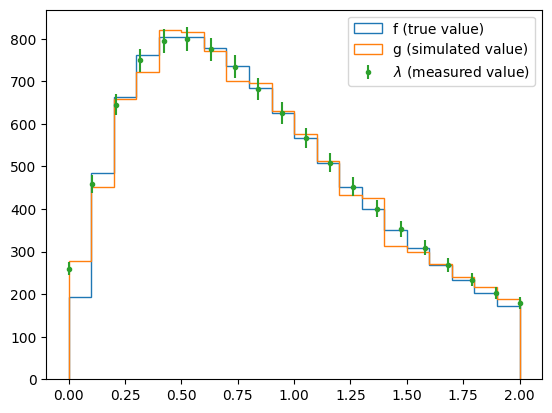

In [227]:
x=np.linspace(0,2,len(f))

plt.hist(x,weights=f, label='f (true value)', bins=len(f), histtype='step')
plt.hist(x,weights=g(f,A,rng), label='g (simulated value)', bins=len(f), histtype='step')
plt.errorbar(x,lam(f,A),np.sqrt(lam(f,A)), fmt='.', label='$\lambda$ (measured value)')
plt.legend()

## c) Folding A=U*D*U⁻¹

    g=U*D*U⁻¹ f 
<=> U⁻¹ g = DU⁻¹f 

<=> c = b


where c = U⁻¹ g, 
b = DU⁻¹ f

Advantages: 

1. Diagonal matrices (D) are easier to invert
2. Orthogonal matrices (U) are easy to invert U^T=U⁻¹
3. Sorting the eigenvalues in descending order helps in identifying the most significant dimensions

In [228]:
# Eigenwerte & -vektoren 
w,v = np.linalg.eig(A) # gibt EW w und EV v zurück

print(w) 

# Absteigend sortieren
indices = np.argsort(w)[::-1]
w = w[indices]
v = v[:,indices]

print(w)

[0.08566336 0.102514   0.130137   0.16785218 0.21473088 0.26961878
 0.33116437 0.39785218 0.46804015 0.54       0.61195985 0.68214782
 0.74883563 0.81038122 0.86526912 1.         0.99433664 0.977486
 0.949863   0.91214782]
[1.         0.99433664 0.977486   0.949863   0.91214782 0.86526912
 0.81038122 0.74883563 0.68214782 0.61195985 0.54       0.46804015
 0.39785218 0.33116437 0.26961878 0.21473088 0.16785218 0.130137
 0.102514   0.08566336]


In [229]:
D = np.diag(w)
U = v

D_inv = np.linalg.inv(D)
U_inv = np.linalg.inv(U)

## d) Transform f->b and g->c

c = U⁻¹ g 

b = DU⁻¹ f

In [230]:
b = U_inv @ f 
c = D_inv @ U_inv @ g(f,A,rng)

In [231]:
Cov_g = np.diag(lam(f,A))
Cov_c = (D_inv @ U_inv) @ Cov_g @ (D_inv @ U_inv).T

In [232]:
sigma_c = np.sqrt(np.diag(Cov_c)) #standardabweichung von b 
c_hat = b/sigma_c # normiertes b 

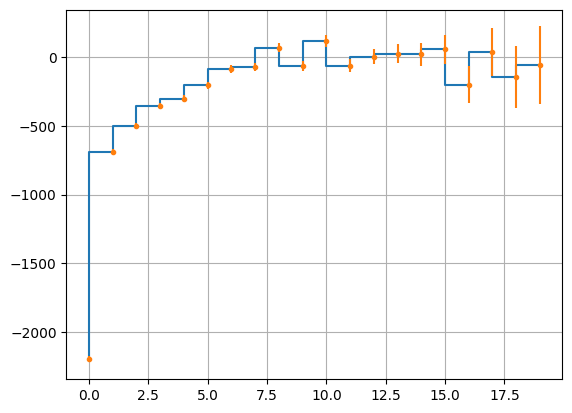

In [233]:
x = np.arange(len(c))

plt.step(x,c)
plt.errorbar(x, c, sigma_c, fmt='.')
plt.grid()

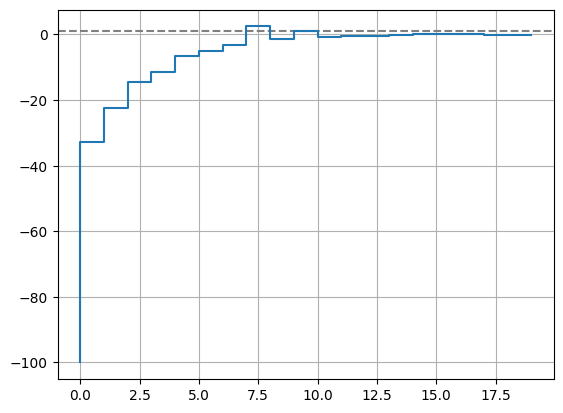

In [234]:
plt.axhline(1, linestyle ='--', color='gray')
plt.step(x,c_hat)
plt.grid()

c_hat < 1 <=> c<c_sigma

standard deviation > value: coefficient is not insignificant from zero,

value contributes no information

## e) Unfolding and Regularization

In [235]:
def unfold(b, Cov_b, U, cut):
    b = b[:cut]
    Cov_b = Cov_b[:cut,:cut]
    U = U[:,:cut]
    
    f = U @ b 
    Cov_f = U @ Cov_b @ U.T
    
    return f, Cov_f

In [236]:
#Entfaltung mit Regularisiren
f_5, Cov_f_5 = unfold(c, Cov_c, U, cut=5)
sigma_f_5 = np.sqrt(np.diag(Cov_f_5))

f_10, Cov_f_10 = unfold(c, Cov_c, U, cut=10)
sigma_f_10 = np.sqrt(np.diag(Cov_f_10))

f_15, Cov_f_15 = unfold(c, Cov_c, U, cut=15)
sigma_f_15 = np.sqrt(np.diag(Cov_f_15))

# Entfaltung ohne Regularisieren
f_20, Cov_f_20 = unfold(c, Cov_c, U, cut=20)
sigma_f_20 = np.sqrt(np.diag(Cov_f_20))


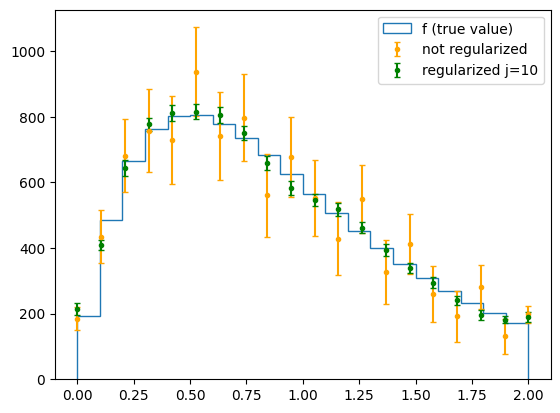

In [237]:
x=np.linspace(0,2,len(f))
plt.hist(x,weights=f, label='f (true value)', bins=len(f), histtype='step')
plt.errorbar(x, f_20, yerr=sigma_f_20, fmt='.', color='orange', capsize=2, label='not regularized')
plt.errorbar(x, f_10, yerr=sigma_f_10, fmt='.', color='green', capsize=2, label='regularized j=10')
plt.legend()

Unregularized solution oscillates.

Regularization suppresses oscillations and thus fits the true values better.